# TASK 1

### Data exploration

First of all I make an initial exploratory analysis of the two datasets.

In [21]:
#Importing basic librearies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [22]:
#Loading data

def Load(filenameL='Courier_lifetime_data.csv',filenameW='Courier_weekly_data.csv'): 
    #Load data from csv file amd make some preprocessing
    
    dataL=pd.read_csv(filenameL)
    dataW=pd.read_csv(filenameW)
    
    
    
    return dataL, dataW

dataL,dataW=Load()

In [23]:
#There are two sources of data for couriers. Lifetime data and weekly data.
#7524 different couriers in dataL and 759 in dataW, all of which are contained 
#in data L
courierL=dataL.courier.unique()
courierW=dataW.courier.unique()
W_in_L=np.intersect1d(courierL,courierW).size
print('# of unique couriers ID in lifetime dataset: {:g}'.format(courierL.size))
print('# of unique couriers ID in weekly dataset: {:g}'.format(courierW.size))
print('# of couriers with weekly data in lifetime dataset: {:g}'.format(W_in_L))


# of unique couriers ID in lifetime dataset: 7524
# of unique couriers ID in weekly dataset: 759
# of couriers with weekly data in lifetime dataset: 759


### About lifetime data (dataL)

Text(0.5,1,'Proportion of nans')

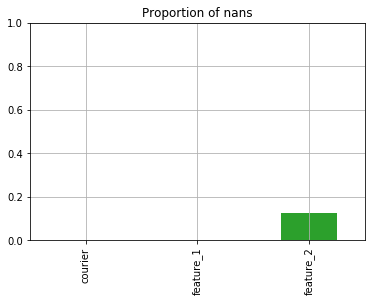

In [24]:
#Nan's check in dataL
plt.figure()
(dataL.isnull().sum()/len(dataL)).plot(kind='bar',ylim=[0,1],grid=True)
plt.title('Proportion of nan''s')


There are no nan's for feature_1 and some 12% for feature_2

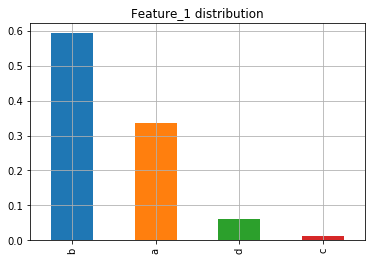

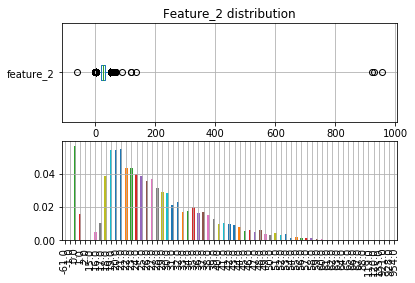

In [25]:
#Data distribution
plt.figure()
plt.title('Feature_1 distribution')
(dataL.feature_1.value_counts()/len(dataL)).plot(kind='bar',grid=True)

plt.figure()
plt.subplot(2,1,1)
plt.title('Feature_2 distribution')
dataL.feature_2.plot.box(vert=False)
plt.grid(True)
plt.subplot(2,1,2)
(dataL.feature_2.value_counts().sort_index()/len(dataL)).plot(kind='bar',grid=True)




Feature_1 is clearly unbalanced, while feature_2 appears to have some clear outliers (negative values and above 100s)

### About weekle data (dataW)

Text(0.5,1,'Proportion of nans')

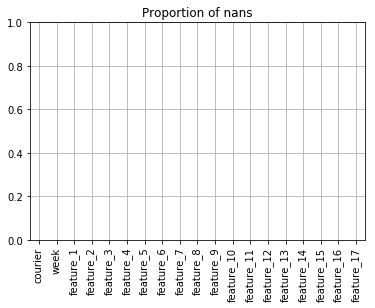

In [26]:
#Nan's checks in dataW
plt.figure()
(dataW.isnull().sum()/len(dataW)).plot(kind='bar',ylim=[0,1],grid=True)
plt.title('Proportion of nan''s')

NO nan's in any of the weekly features!!!

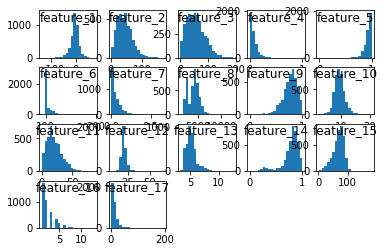

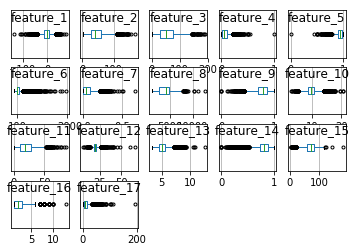

In [27]:
#Data distribution

#Histragrams
plt.figure()
for i in range(1,18):
    plt.subplot(4,5,i)
    S=dataW.iloc[:,i+1]
    ax=S.hist(bins=20,grid=False)
    ax.set_title(S.name,pad=-10)
    
#Boxplots
plt.figure()
for i in range(1,18):
    plt.subplot(4,5,i)
    S=dataW.iloc[:,i+1]
    ax=S.plot.box(vert=False,sym='.')
    ax.set_title(S.name,pad=-10)
    ax.set_yticks([])
    plt.grid(True)

The density distribution of the different features ranges among normal-like, exponential and logaritmic distributions.

There seems to be some serious outliers and also some intense collinearity (same or simetric distribution shapes). This last characteric can be shown clearly computing the correlation matrix of the different features. However I will show the correlation after munging below both datasets, lifetime and weekly.

### Munging the L and W datasets

Now we have an idea of how the data is distributed we can think the best way to munge it in to
one sole dataset.

Couriers without week data (89.9% of the total) have the same label at best (label 1 since they have not weeks 9,10 and 11 provided) or unknown otherwise. Although they represent a high proportion of the couriers, their lack of week data make me forget about them at least initially to avoid overfitting (since to use them I would have to fill their empty weekly data with average values that would probably introduce noise). Therefore I will only use courier data with week data (i.e. 759 couriers)

Now there are three options:

A) Compute means from couriers week data. Contrary to A case, this means less examples but maybe with less noise.

B) Add the standard from couriers week data. There can be useful information for classifying couriers with small or large weekly std.

C) Fit our model using any week data as it would correspond to different couriers. This way has the advantage of provide a larger number of example for the learning process but maybe adding some noise

In [28]:
#Initial munging

def MungingData(k=6.5, case='median'):
    
    #k is the coeficient used to filter possible outliers
    
    dataL,dataW=Load()

    dataL=dataL.set_index('courier')
    dataL.columns=['feature_1L','feature_2L']
    dataW=dataW.set_index('courier')
    dataLW=pd.concat([dataL,dataW],axis=1,join='inner')

    #Feature_1L
    #Converting categorical data to numerical data
    dataLW=pd.get_dummies(dataLW)

    ##Feature_2L
    #Substituting nan's by feature median
    feature_2L_M=dataLW.feature_2L.median()
    dataLW.feature_2L.fillna(feature_2L_M,inplace=True)

    #Outliers
    #Removing possible outlier (those out of Median+- k*STD)
    STD=dataLW.std()
    MED=dataLW.median()
    dataLW=dataLW[(dataLW<(MED+k*STD)) & (dataLW>(MED-k*STD))].dropna(how='any',axis=0)

    #Removing weeks 8,9,10 and 11
    dataLW=dataLW[dataLW.week<8]
    #Remove week data
    dataLW=dataLW.drop('week',axis=1)
    
    # A) WEEKLY AVERAGES DATA
    if case=='median':
        dataLW=dataLW.groupby(dataLW.index).median()
     
    # B) ADDING WEEKLY STD DATA
    if case=='median_std':
        dataLWm=dataLW.groupby(dataLW.index).median()
        
        dataLWstd=dataLW.groupby(dataLW.index).std()
        dataLWstd.fillna(0,inplace=True)
        dataLWstd.columns=[col+'_std' for col in dataLWstd.columns.tolist()]
        
        dataLW=pd.concat([dataLWm,dataLWstd],axis=1)
        
    # C) OTHERWISE, USE OF WEEKLY DATA
    
    return dataLW

dataLW=MungingData(k=6.5,case='median')

### Labelling data

In [29]:

def Labelling(dataLW,Fprint=False):
    
    #Loading original data
    _,dataW0=Load()

    #Selecting courier ID with 9,10 and 11 week data
    i3=dataW0.courier[(dataW0.week>=9) & (dataW0.week<=11)].value_counts()==3
    c0=i3[i3].index
    
    if Fprint:
        print('# of couriers with label 0: {:g} ({:g}%)'.format(c0.size,c0.size/759))
        print('# of couriers with label 1: {:g} ({:g}%)'.format(759-c0.size,1-c0.size/759))

    #Labels
    #Label 0 for those with 9, 10 and 11 week data and Label 1 for the rest
    labels=pd.Series(1,dataLW.index,name='labels')
    labels.loc[np.intersect1d(c0,dataLW.index)]=0
    
    return labels

labels=Labelling(dataLW,Fprint=True)

# of couriers with label 0: 124 (0.163373%)
# of couriers with label 1: 635 (0.836627%)


It is obvious that courier classes are highly unbalanced. I will have to take this into account when fitting the model but also when evaluating it


### Correlations

I can finally compute the correlation matrix but I will also include the labels to have an idea of feature-label relations

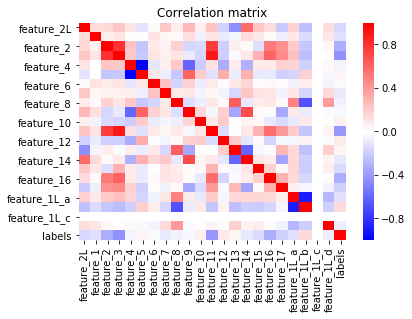

In [30]:
#Correlations

#Including labels
dataLW_L=pd.concat((dataLW,labels),axis=1)

#Computing correlations
C=dataLW_L.corr()
                        
#Ploting the correlation matrix as a heatmap
plt.figure()
plt.title('Correlation matrix')
sns.heatmap(C,vmin=-1,vmax=1,cmap=cm.bwr)

It is quite clear that there are intense correlations between several features, especially between (feature_3 and feature_2), (feature_4 and feature_4), (feature_11 and feature_2 and 3) etc....

Respect to relations between features and labels it seems that feature_2, feature_3 and feature_11 have the strongest correlations.

Since I will use a Logistic Regression model I will have to ensure that there is no collinearity among features and that they are standarized/scaled to same ranges.

Standarization and orthogonalization (principal component analysis) will be done in the next section.



# TASK 2

### Preparing data for fitting the Logistic Regression model

In order to fit the model we first need a training and a test sets. 


In [31]:
#Importing needed modules

import itertools

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer,confusion_matrix


In [32]:
#Data is splitted into training and test. Standarization and orthogonalization is created from 
#training data and the used to standarize and orthogonalize test data.

def Split_TrainTest(k=6.5,case='weekly',test_size=0.1):
    
    dataLW=MungingData(k=k, case=case)
    labels=Labelling(dataLW)
    
    
    #TrainSplit
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(dataLW.values,labels.values,
                                               test_size=test_size, random_state=0)

    #Standarization
    scaler=MinMaxScaler(feature_range=(0,1))
    Xtrain=scaler.fit_transform(Xtrain)
    Xtest=scaler.transform(Xtest)


    #Principal Components
    pca=PCA()
    Xtrain=pca.fit_transform(Xtrain)
    Xtest=pca.transform(Xtest)
    
    return Xtrain,Xtest,Ytrain,Ytest

Xtrain,Xtest,Ytrain,Ytest=Split_TrainTest(k=6.5,case='weekly',test_size=0.1)


### Model implementation

A Logistic Regression model is fitted using a grid search cross-validation for different hyperparameter and training set configurations. The hyperparameters are:

Features hyperparameters:

. k: It is the coeficient for the outliers filter used in the MungingData function. It multiplies the std of each feature range to cut off entries out of Median+-k·STD.

. case: It sets how the weekly data from each courier is munge. 'weekly' does not compile each week entry but instead each one is used for fitting the model as a single different courier entry. 'median' compiles the weekly data for each courier taking the median of all weeks. 'std' adds the weekly standard deviations of the couriers for each feature.

. penalty: It is used for regularization and thus to reduce overfitting. There are two types of regularization in Logistic Regression; 'l1' or 'l2' depending on using absolute or squared magnitudes of coefficients as penalty term to the loss function

. C: It is the inverse coeficient for the corresponding regularization. Higher/lower values implies softer/stronger regularization.

. solver: It is the optimization algorithm: 'liblinear' and 'saga'. They are the only ones that hold l1 and l2 regularization. 

In [36]:
#Features hyperparameters
k=np.arange(2,10,0.5)
case=['weekly','median','median_std']

#Model hyperparameters
penalty=['l1','l2']
C=[0.2,0.5,1,2,5,10,20]
solver=['liblinear','saga']

#Defining the combination of all parameters
params=[(ki,ci,pi,Ci,si) for ki in k for ci in case for pi in penalty for Ci in C for si in solver]

#I will use the weighted mean of precisions achieved at each threshold as scoring metric,
#I will explained it in the last section
scoring={'ACCscore':make_scorer(accuracy_score),
         'bACCscore':make_scorer(balanced_accuracy_score),
         'Rscore':make_scorer(recall_score),
         'Pscore':make_scorer(precision_score),
         'aucROCscore':make_scorer(roc_auc_score),}


def CrossValidation(params,scoring):
        
    #Dataframe to contain all combination scores
    #scores=pd.DataFrame(columns=['Train_score','Val_score','Baseline_score'],index=params)
    scores=pd.DataFrame(columns=['ACC_val','bACC_val','Recall_val','Precision_val',
                                 'aucROC_train','aucROC_val','aucROC_baseline'],index=params)


    for (ki,ci,pi,Ci,si) in params:
        
        #Creating model input data depending on each feature hyperparameter.
        #Here is important to note that since random_state is fixed (=0), all combinations
        #are always trained with the same proportion of the dataset and the test set is 
        #correspondingly the same that will be used at the end for final evaluation.
        #
    
        Xtrain,Xtest,Ytrain,Ytest=Split_TrainTest(k=ki,case=ci)
    
        #Defining model with corresponding hyperparameter. "class_weight" it is used to balance
        #the unbalance class set
        LRmodel=LogisticRegression(class_weight='balanced',
                                   solver=si,
                                   penalty=pi,
                                   C=Ci)

        #Result of the cross-validation. Cross-validation is evaluated on the training set and
        # on the validation set automatically created by cross_validate function.
        cv_results=cross_validate(LRmodel,Xtrain,Ytrain,
                                  cv=3,return_train_score=True,
                                  scoring=scoring)
    
    
        #Adding results to the DataFrame for train and validation sets
        #ACCtrain=cv_results['train_ACCscore'].mean()
        ACCval=cv_results['test_ACCscore'].mean()
        
        #bACCtrain=cv_results['train_bACCscore'].mean()
        bACCval=cv_results['test_bACCscore'].mean()
        
        #Rtrain=cv_results['train_Rscore'].mean()
        Rval=cv_results['test_Rscore'].mean()
        
        #Ptrain=cv_results['train_Pscore'].mean()
        Pval=cv_results['test_Pscore'].mean()
        
        AUCtrain=cv_results['train_aucROCscore'].mean()
        AUCval=cv_results['test_aucROCscore'].mean()
        
        #The baseline would be an array of the most frequent label, that is 1
        Y_baseline=np.ones(Ytrain.shape)
        aucROC_baseline=roc_auc_score(Ytrain,Y_baseline)
        
        scores.loc[(ki,ci,pi,Ci,si)]=[ACCval,bACCval,Rval,Pval,
                                      AUCtrain,AUCval,aucROC_baseline]
        
        
    return scores
    
scores=CrossValidation(params,scoring)

#This computation may take one or two minutes
#Some warning may appear from some problematic combinations, but enough good results are
#computed and shown below  

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_inde

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/skle

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/py

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(self._maybe_cast_indexer(key))
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/base.py:3066: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/skle

/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/susopeiz/anaconda2/envs/py36/lib/python3.6/site-packages/skle

# TASK 3

### The evaluation metrics

First of all, since the dataset is quite unbalanced, using just accuracy would not be very informative of the goodness of the classifier since the baseline would be around 80% (a prediction with all labels = 1).

To decide the best evaluation metric I would need to know the aim of the prediction, for example whether we are interested in True positive more than in False positive. In these case I could focus on the precision or recall score knowing that both metrics depends on the ratio of the two classes in the datasets

Since I don't know the focus of this study I will focus on optimizing the general prediction capacity of the classifier, i.e. maximizing the true positives but also minizing the false positives. For this purpose I will use the ROC curve (Receiver operating characteristic). This metric computes the ratio of true positives vs false positives for different thresholds (probabilities of being one or other class estimated by the classifier). It does not depend on the proportion of classes in the datasets.

The area under the ROC (auc ROC) can be understood as the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. For this reason the baseline of the auc ROC is 0.5

### Results

,ACC_val,bACC_val,Recall_val,Precision_val,aucROC_train,aucROC_val,aucROC_baseline
"(2.5, median, l1, 0.5, liblinear)",0.731656,0.757997,0.713911,0.934671,0.763903,0.757997,0.5
"(5.5, median, l2, 20, liblinear)",0.7712,0.759886,0.777478,0.936571,0.764601,0.759886,0.5
"(5.5, median, l2, 20, saga)",0.7712,0.759886,0.777478,0.936571,0.764601,0.759886,0.5
"(4.0, median_std, l1, 0.5, saga)",0.745561,0.760579,0.737375,0.940106,0.770747,0.760579,0.5
"(5.5, median, l2, 2, liblinear)",0.761955,0.761199,0.762559,0.939104,0.767555,0.761199,0.5
"(5.5, median, l2, 2, saga)",0.761955,0.761199,0.762559,0.939104,0.768023,0.761199,0.5
"(5.5, median, l2, 5, saga)",0.768113,0.761474,0.771881,0.937987,0.764132,0.761474,0.5
"(5.5, median, l2, 5, liblinear)",0.768113,0.761474,0.771881,0.937987,0.764132,0.761474,0.5
"(5.5, median, l2, 10, liblinear)",0.7712,0.763341,0.775616,0.938261,0.765536,0.763341,0.5
"(5.5, median, l2, 10, saga)",0.7712,0.763341,0.775616,0.938261,0.765536,0.763341,0.5


<Figure size 432x288 with 0 Axes>

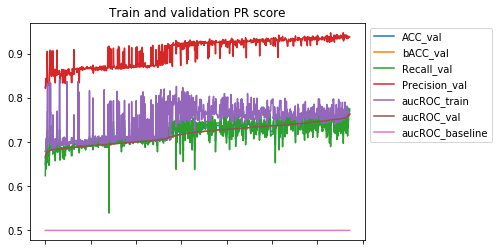

In [37]:
# Plotting increasingly better combination of hyperparameters
plt.figure()
ax=scores.sort_values(by=['aucROC_val']).plot() 
plt.title('Train and validation PR score')
ax.legend(bbox_to_anchor=(1,1))

#Best 10 combinations
scores.sort_values(by='aucROC_val').tail(10)

### Best hyperparameter combination

Finally the best validation score is auc ROC = 0.7633 and it is obtained for the combination:

 k = 5.5 , case = 'median' , penalty = 'l2' , C = 10 , solver = 'liblinear'
 
Overfitting appears to be minimal.

case       Baseline  Prediction
metric                         
ACC        0.847222    0.694444
bACC       0.500000    0.596125
Recall     1.000000    0.737705
Precision  0.847222    0.882353
aucROC     0.500000    0.700447


<Figure size 432x288 with 0 Axes>

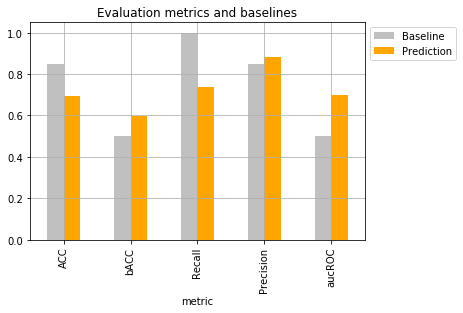

In [167]:

#Features hyperparameters
k=5.5
case='median'

#Model hyperparameters
penalty='l2'
C=10
solver='liblinear'

def ClassifierEvaluation(k,case,penalty,C,solver):
     
    #Splitting
    Xtrain,Xtest,Ytrain,Ytest=Split_TrainTest(k=k,case=case)
    
    #Model definition  
    LRmodel=LogisticRegression(class_weight='balanced',
                               solver=solver,
                               penalty=penalty,
                               C=C)
    #Fitting
    LRmodel.fit(Xtrain,Ytrain)
    
    #Predicting
    Ypredtest=LRmodel.predict(Xtest)
    Yprobtest=LRmodel.predict_proba(Xtest)
    
    #Scoring
    ACC=accuracy_score(Ytest,Ypredtest)
    bACC=balanced_accuracy_score(Ytest,Ypredtest)
    R=recall_score(Ytest,Ypredtest)
    P=precision_score(Ytest,Ypredtest)
    
    aucROC=roc_auc_score(Ytest,Yprobtest[:,1])
    ROC=roc_curve(Ytest,Yprobtest[:,1])
    
    #Baselines
    Y_baseline=np.ones(Ytest.shape)
      
    ACC_baseline=accuracy_score(Ytest,Y_baseline)
    bACC_baseline=balanced_accuracy_score(Ytest,Y_baseline)
    R_baseline=recall_score(Ytest,Y_baseline)
    P_baseline=precision_score(Ytest,Y_baseline)    
    aucROC_baseline=roc_auc_score(Ytest,Y_baseline)
     
        
    scores=[ACC,ACC_baseline,
            bACC,bACC_baseline,
            R,R_baseline,
            P,P_baseline,
            aucROC,aucROC_baseline]
    
    metrics0=['ACC','bACC','Recall','Precision','aucROC']
    cases0=['Prediction','Baseline']
    metrics=np.repeat(metrics0,repeats=2).tolist()
    cases=cases0*len(metrics0)
    
    dfScores=pd.DataFrame({'value':scores,'metric':metrics,'case':cases})
    dfScores=pd.pivot_table(dfScores,columns=['case'],values='value',index='metric').reindex(index=metrics0)

    return dfScores

dfScores=ClassifierEvaluation(k,case,penalty,C,solver)

#Showing the final results
plt.figure()
ax1=dfScores.plot.bar(color=['silver','orange'])
plt.grid(True)
plt.title('Evaluation metrics and baselines')
ax1.legend(bbox_to_anchor=(1,1))

print(dfScores)

### Test set evaluation

The final results for the test set reduce a bit the scores but still gets aucROC=70% of probabilities of predicting a correct label better than pure random. The baseline for the aucROC equals 50%

Comparing with other metrics and their respective baseline (baseline computed from all predicted classes equals most frequent class):
· It gets 69.4% for general accuracy while the baseline is 84.7%, not providing too much information here. 

· However if I use balanced accuracy (i.e the mean of accuracies for each class since they are higly unbalanced) I obtain 59.6% above the baseline of 50%. 

·The proportion of all positive elements being predicted is recall and it gets=73.8%. The baseline here is 100% but again not too useful.

· Finally the proportion of correct predicted positives is precision_val=88.2% more than the baseline=84.7%.

